## Gathering Data form Patentsview API 2010-2015, include the variables we want

#### Skip this step if you do not want to get the data yourself

In [ ]:
#import necessary packages
import requests 
import json # read/write JavaScript Object Notation (JSON)

import pandas as pd 
# normalize nested JSON files
from pandas.io.json import json_normalize

In [ ]:
# Save the URL in an object
base_url = 'http://www.patentsview.org/api/patents/query?'

# Save the query criterion in an object
criterion = 'q={"_and":[{"_eq":{"patent_year":"2010"}},{"_eq":{"patent_firstnamed_assignee_country":"US"}},{"_eq":{"patent_firstnamed_inventor_country":"US"}}]}'

#same for field
field = '&f=["patent_number","patent_title","patent_abstract","patent_num_cited_by_us_patents","patent_date","app_date","inventor_first_name","inventor_last_name","patent_firstnamed_inventor_city","patent_firstnamed_inventor_state","assignee_organization","patent_firstnamed_assignee_city","patent_firstnamed_assignee_state","lawyer_id", "lawyer_total_num_patents", "app_type","assignee_total_num_patents","assignee_type", "cpc_first_seen_date", "cpc_category","cpc_section_id", "examiner_first_name","examiner_last_name", "examiner_id", "examiner_role","examiner_group","patent_date"]'

#check the entries
print(base_url)
print(criterion)
print(field)

In [ ]:
#for loop to run through all pages of the call, store results in a dataframe, normalize the json entries, and merge back together
patent_all = {} #create empty data frame to use later
for i in range(10):
    url = base_url + criterion + field + '&o={"page":' + str(i+1) + ',"per_page":10000}' #our query uses the for loop to run through all 10 pages of results
    r = requests.get(url)
    response = r.json() 
    pat18 = pd.DataFrame(response['patents']) #store results in a dataframe
    pat_cut = pat18[['patent_abstract', 'patent_date',
       'patent_firstnamed_assignee_city', 'patent_firstnamed_assignee_state',
       'patent_firstnamed_inventor_city', 'patent_firstnamed_inventor_state',
       'patent_num_cited_by_us_patents', 'patent_number', 'patent_title']] #save the dataframe that doesn't have the json entries
    patent_app_date = (json_normalize(response['patents'], record_path='applications', meta=['patent_number','patent_title'])) #normalize the columns we need to
    patent_assignees = (json_normalize(response['patents'], record_path='assignees', meta=['patent_number','patent_title']))
    patent_inv = (json_normalize(response['patents'], record_path='inventors', meta=['patent_number','patent_title']))
    patent_cpcs = (json_normalize(response['patents'], record_path='cpcs', meta=['patent_number','patent_title']))
    patent_exam = (json_normalize(response['patents'], record_path='examiners', meta=['patent_number','patent_title']))
    patent_law = (json_normalize(response['patents'], record_path='lawyers', meta=['patent_number','patent_title']))
    patent_date_assignee = patent_app_date.merge(patent_assignees,on=['patent_number','patent_title']) #merge normalized json results back together
    patent_date_inv = patent_date_assignee.merge(patent_inv, on = ['patent_number', 'patent_title'])
    patent_cpcs_exam = patent_cpcs.merge(patent_exam, on = ['patent_number', 'patent_title'])
    patent_cpexam_law = patent_cpcs_exam.merge(patent_law, on = ['patent_number', 'patent_title'])
    patent_1 = patent_date_inv.merge(patent_cpexam_law, on = ['patent_number', 'patent_title'])
    patent_all[i] = pat_cut.merge(patent_1, on = ['patent_number', 'patent_title']) #merge final normalized jsons back into original dataframe, will give us unique dataframe for each page of results

In [ ]:
#get rid of multiple entries, just look at first inventor for each
pat0 = patent_all[0].groupby('patent_number').first()
pat1 = patent_all[1].groupby('patent_number').first()
pat2 = patent_all[2].groupby('patent_number').first()
pat3 = patent_all[3].groupby('patent_number').first()
pat4 = patent_all[4].groupby('patent_number').first()
pat5 = patent_all[5].groupby('patent_number').first()
pat6 = patent_all[6].groupby('patent_number').first()
pat7 = patent_all[7].groupby('patent_number').first()
pat8 = patent_all[8].groupby('patent_number').first()
pat9 = patent_all[9].groupby('patent_number').first()

In [ ]:
#merge all dataframes into one master one and we're done
pat01 = pat0.merge(pat1, how = 'outer')
pat23 = pat2.merge(pat3, how = 'outer')
pat45 = pat4.merge(pat5, how = 'outer')
pat67 = pat6.merge(pat7, how = 'outer')
pat89 = pat8.merge(pat9, how = 'outer')
pat0123 = pat01.merge(pat23, how = 'outer')
pat4567 = pat45.merge(pat67, how = 'outer')
pat456789 = pat4567.merge(pat89, how = 'outer')
pat_all = pat0123.merge(pat456789, how ='outer')
pat_all

In [ ]:
pat_all.to_csv('pat10.csv')

### Repeat the steps above for each year of our data to give us a csv per year

## DataFrame Creation/Manipulation

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn #machine learning
from datetime import date #handles dates

# record linkage 
import recordlinkage as rl
from recordlinkage.preprocessing import clean, phonenumbers, phonetic

#for regression model
import statsmodels.formula.api as smf

#regularization
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [2]:
#so we can see all columns
pd.set_option('display.max_columns', 500)

In [3]:
#read in our data
pat10 = pd.read_csv('pat10.csv')
pat11 = pd.read_csv('pat11.csv')
pat12 = pd.read_csv('pat12.csv')
pat13 = pd.read_csv('pat13.csv')
pat14 = pd.read_csv('pat14.csv')
pat15 = pd.read_csv('pat15.csv')

/Users/johnhughes/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/johnhughes/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#put all years in 1 dataframe
pat = pd.concat([pat10,pat11,pat12,pat13,pat14,pat15], ignore_index = True)

In [5]:
pat['patent_date'] = pd.to_datetime(pat['patent_date']) #so we read as date
pat['app_date'] = pd.to_datetime(pat['app_date']) #so we read as date
pat['time_lag'] = pat.patent_date - pat.app_date #get our time difference - dependent variable
pat['days'] = pat['time_lag'].dt.days #make an int
pat.drop(['time_lag'], axis = 1, inplace = True)

In [6]:
#Focus on primary for this project, majority of entries
patents = pat[pat['examiner_role'] == 'primary'] 
patents.shape

(487279, 30)

In [7]:
#create full name based on first & last to link same examiner together
patents['name_last']=(clean(patents['examiner_last_name'], 
                                 lowercase=True, remove_brackets=True))
patents['name_first']=(clean(patents['examiner_first_name'], 
                                  lowercase=True, remove_brackets=True))

patents['examiner_name'] = patents.name_first + ' ' + patents.name_last

/Users/johnhughes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/johnhughes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/johnhughes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [8]:
#Create unique ID for each examiner so we can measure effects, Same Name + Same EX group = same person
patentsC = patents
patentsC['id'] = 0
patentsC['id'] = patentsC.groupby(['examiner_name','examiner_group']).ngroup()
patentsC.id.nunique()

/Users/johnhughes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/johnhughes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


18142

In [9]:
#The above creates new unneccessary variables, get them out
pat = patentsC.drop(['Unnamed: 0','lawyer_id', 'lawyer_total_num_patents', 'examiner_id', 'examiner_role'], axis = 1)
pat.head()

,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_category,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,name_last,name_first,examiner_name,id
0,A pre-assembled anti-creep waist-clothing stay...,2010-01-05,Baltimore,MD,Baltimore,MD,1,Assembled anti-creep waist-clothing stay devic...,2005-04-01,11/096666,11,372508,"ProductMasters, Inc.",1,2,Catherine,2528735,Chetelat,inventional,1976-01-06,A,Katherine,3765,Moran,1740,moran,katherine,katherine moran,9116
1,A bed rail structured to minimize the gap betw...,2010-01-05,Prior Lake,MN,Lakeville,MN,15,Mattress hugging bed rail,2007-10-31,11/981628,11,156296,"Regalo International, LLC",46,2,Nathan A,2182193,Dusheck,inventional,1976-01-06,A,Robert G,3673,Santos,797,santos,robert g,robert g santos,14021
2,A patient support system includes a patient su...,2010-01-05,Palo Alto,CA,Saratoga,CA,33,Patient support systems,2006-05-01,11/415974,11,34467,"Varian Medical Systems, Inc.",686,2,Stanley,584137,Mansfield,inventional,1976-01-06,A,Michael,3673,Trettel,1345,trettel,michael,michael trettel,11723
3,A medical examination table which is movable b...,2010-01-05,Versailles,OH,Greenville,OH,7,Medical examination table,2002-10-11,10/269347,10,193632,Midmark Corporation,117,2,Richard L.,697895,Turner,inventional,1976-01-06,A,Frederick,3673,Conley,2643,conley,frederick,frederick conley,5374
4,A headrest assembly (212) for supporting a fac...,2010-01-05,Vista,CA,San Diego,CA,5,Headrest assembly for a massage device,2006-06-13,11/452728,11,311764,"Earthlite Massage Tables, Inc.",21,2,William W.,600853,Chow,inventional,1976-01-06,A,Robert G,3673,Santos,1302,santos,robert g,robert g santos,14021


In [10]:
#number of patents examiner exams in this period
excount = pat.groupby(["id"])["app_id"].count().reset_index(name="patents_examined")
pat_ = pat.merge(excount, left_on = 'id', right_index = True, how = 'inner')

#The above creates new unneccessary variables, get them out
pat_ = pat_.drop(['id_x', 'id_y', 'name_first', 'name_last'], axis = 1)

In [11]:
#focus on one category to get noise out, majority of entries
pat_ = pat_[pat_['cpc_category'] == 'inventional']
pat_ = pat_.drop(['cpc_category'], axis = 1)

In [12]:
#Measure differences accross the year a patent was applied for and awarded
pat_['year'] = pat_['patent_date'].dt.year
pat_['app_year'] = pat_['app_date'].dt.year

In [13]:
#proxy for examiner experience
exyear = pat_.groupby(["id"])["app_year"].min().reset_index(name="ex_first_appeared")
pat_ = pat_.merge(exyear, left_on = 'id', right_index = True, how = 'inner')
pat_ = pat_.drop(['id_x', 'id_y'], axis = 1)
pat_.head()

,id,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,examiner_name,patents_examined,year,app_year,ex_first_appeared
0,9116,A pre-assembled anti-creep waist-clothing stay...,2010-01-05,Baltimore,MD,Baltimore,MD,1,Assembled anti-creep waist-clothing stay devic...,2005-04-01,11/096666,11,372508,"ProductMasters, Inc.",1,2,Catherine,2528735,Chetelat,1976-01-06,A,Katherine,3765,Moran,1740,katherine moran,92,2010,2005,2006
1506,9116,A protective glove for a firefighter or for an...,2010-01-12,Dayton,OH,Dayton,OH,9,Protective glove having inspection port,2006-02-07,11/348680,11,264627,"Morning Pride Manufacturing, L.L.C.",91,2,William L.,769984,"Grilliot, Jr.",1976-01-06,A,Katherine,3765,Moran,1435,katherine moran,92,2010,2006,2006
16222,9116,A head shield device having a frame and a repl...,2010-03-23,Bentonville,AR,San Diego,CA,25,Rotating lens locking device,2006-08-28,11/511865,11,47870,"JT Sports, LLC",19,2,Lester V.,3632185,Broersma,1976-01-27,A,Katherine,3765,Moran,1303,katherine moran,92,2010,2006,2006
21651,9116,A sports glove comprising a dorsal side and at...,2010-04-13,St. Louis,MO,Altamont,NY,6,Sports glove with a segmented joint protector,2007-05-25,11/754239,11,47078,"Rawlings Sporting Goods Company, Inc.",93,2,Paul J.,1760068,Gait,1976-01-06,A,Katherine,3765,Moran,1054,katherine moran,92,2010,2007,2006
23442,9116,An improved goggle strap is provided. The stra...,2010-04-20,Burbank,CA,Dallas,PA,1,Goggle strap,2005-11-23,11/286048,11,196957,"Aramark Cleanroom Services, LLC",1,2,Edward,2557662,Pennell,1976-01-06,A,Katherine,3765,Moran,1609,katherine moran,92,2010,2005,2006


In [14]:
#total citations examiners have granted 
expat = pat_.groupby(["id"])["patent_num_cited_by_us_patents"].sum().reset_index(name="ex_citations")
pat_ = pat_.merge(expat, left_on = 'id', right_index = True, how = 'inner')
pat_ = pat_.drop(['id_x', 'id_y'], axis = 1)
pat_.head()

,id,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,examiner_name,patents_examined,year,app_year,ex_first_appeared,ex_citations
0,9116,A pre-assembled anti-creep waist-clothing stay...,2010-01-05,Baltimore,MD,Baltimore,MD,1,Assembled anti-creep waist-clothing stay devic...,2005-04-01,11/096666,11,372508,"ProductMasters, Inc.",1,2,Catherine,2528735,Chetelat,1976-01-06,A,Katherine,3765,Moran,1740,katherine moran,92,2010,2005,2006,162
1506,9116,A protective glove for a firefighter or for an...,2010-01-12,Dayton,OH,Dayton,OH,9,Protective glove having inspection port,2006-02-07,11/348680,11,264627,"Morning Pride Manufacturing, L.L.C.",91,2,William L.,769984,"Grilliot, Jr.",1976-01-06,A,Katherine,3765,Moran,1435,katherine moran,92,2010,2006,2006,162
16222,9116,A head shield device having a frame and a repl...,2010-03-23,Bentonville,AR,San Diego,CA,25,Rotating lens locking device,2006-08-28,11/511865,11,47870,"JT Sports, LLC",19,2,Lester V.,3632185,Broersma,1976-01-27,A,Katherine,3765,Moran,1303,katherine moran,92,2010,2006,2006,162
21651,9116,A sports glove comprising a dorsal side and at...,2010-04-13,St. Louis,MO,Altamont,NY,6,Sports glove with a segmented joint protector,2007-05-25,11/754239,11,47078,"Rawlings Sporting Goods Company, Inc.",93,2,Paul J.,1760068,Gait,1976-01-06,A,Katherine,3765,Moran,1054,katherine moran,92,2010,2007,2006,162
23442,9116,An improved goggle strap is provided. The stra...,2010-04-20,Burbank,CA,Dallas,PA,1,Goggle strap,2005-11-23,11/286048,11,196957,"Aramark Cleanroom Services, LLC",1,2,Edward,2557662,Pennell,1976-01-06,A,Katherine,3765,Moran,1609,katherine moran,92,2010,2005,2006,162


In [15]:
#how many different application types an examiner has examined
expat = pat_.groupby(["id"])["app_type"].nunique().reset_index(name="ex_app_types")
pat_ = pat_.merge(expat, left_on = 'id', right_index = True, how = 'inner')
pat_ = pat_.drop(['id_x', 'id_y'], axis = 1)
pat_.head()

,id,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,examiner_name,patents_examined,year,app_year,ex_first_appeared,ex_citations,ex_app_types
0,9116,A pre-assembled anti-creep waist-clothing stay...,2010-01-05,Baltimore,MD,Baltimore,MD,1,Assembled anti-creep waist-clothing stay devic...,2005-04-01,11/096666,11,372508,"ProductMasters, Inc.",1,2,Catherine,2528735,Chetelat,1976-01-06,A,Katherine,3765,Moran,1740,katherine moran,92,2010,2005,2006,162,3
1506,9116,A protective glove for a firefighter or for an...,2010-01-12,Dayton,OH,Dayton,OH,9,Protective glove having inspection port,2006-02-07,11/348680,11,264627,"Morning Pride Manufacturing, L.L.C.",91,2,William L.,769984,"Grilliot, Jr.",1976-01-06,A,Katherine,3765,Moran,1435,katherine moran,92,2010,2006,2006,162,3
16222,9116,A head shield device having a frame and a repl...,2010-03-23,Bentonville,AR,San Diego,CA,25,Rotating lens locking device,2006-08-28,11/511865,11,47870,"JT Sports, LLC",19,2,Lester V.,3632185,Broersma,1976-01-27,A,Katherine,3765,Moran,1303,katherine moran,92,2010,2006,2006,162,3
21651,9116,A sports glove comprising a dorsal side and at...,2010-04-13,St. Louis,MO,Altamont,NY,6,Sports glove with a segmented joint protector,2007-05-25,11/754239,11,47078,"Rawlings Sporting Goods Company, Inc.",93,2,Paul J.,1760068,Gait,1976-01-06,A,Katherine,3765,Moran,1054,katherine moran,92,2010,2007,2006,162,3
23442,9116,An improved goggle strap is provided. The stra...,2010-04-20,Burbank,CA,Dallas,PA,1,Goggle strap,2005-11-23,11/286048,11,196957,"Aramark Cleanroom Services, LLC",1,2,Edward,2557662,Pennell,1976-01-06,A,Katherine,3765,Moran,1609,katherine moran,92,2010,2005,2006,162,3


In [16]:
#How many different cpc sctions an examiner has examined in
expat = pat_.groupby(["id"])["cpc_section_id"].nunique().reset_index(name="ex_cpc_sections")
pat_ = pat_.merge(expat, left_on = 'id', right_index = True, how = 'inner')
pat_ = pat_.drop(['id_x', 'id_y'], axis = 1)
pat_.head()

,id,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,examiner_name,patents_examined,year,app_year,ex_first_appeared,ex_citations,ex_app_types,ex_cpc_sections
0,9116,A pre-assembled anti-creep waist-clothing stay...,2010-01-05,Baltimore,MD,Baltimore,MD,1,Assembled anti-creep waist-clothing stay devic...,2005-04-01,11/096666,11,372508,"ProductMasters, Inc.",1,2,Catherine,2528735,Chetelat,1976-01-06,A,Katherine,3765,Moran,1740,katherine moran,92,2010,2005,2006,162,3,2
1506,9116,A protective glove for a firefighter or for an...,2010-01-12,Dayton,OH,Dayton,OH,9,Protective glove having inspection port,2006-02-07,11/348680,11,264627,"Morning Pride Manufacturing, L.L.C.",91,2,William L.,769984,"Grilliot, Jr.",1976-01-06,A,Katherine,3765,Moran,1435,katherine moran,92,2010,2006,2006,162,3,2
16222,9116,A head shield device having a frame and a repl...,2010-03-23,Bentonville,AR,San Diego,CA,25,Rotating lens locking device,2006-08-28,11/511865,11,47870,"JT Sports, LLC",19,2,Lester V.,3632185,Broersma,1976-01-27,A,Katherine,3765,Moran,1303,katherine moran,92,2010,2006,2006,162,3,2
21651,9116,A sports glove comprising a dorsal side and at...,2010-04-13,St. Louis,MO,Altamont,NY,6,Sports glove with a segmented joint protector,2007-05-25,11/754239,11,47078,"Rawlings Sporting Goods Company, Inc.",93,2,Paul J.,1760068,Gait,1976-01-06,A,Katherine,3765,Moran,1054,katherine moran,92,2010,2007,2006,162,3,2
23442,9116,An improved goggle strap is provided. The stra...,2010-04-20,Burbank,CA,Dallas,PA,1,Goggle strap,2005-11-23,11/286048,11,196957,"Aramark Cleanroom Services, LLC",1,2,Edward,2557662,Pennell,1976-01-06,A,Katherine,3765,Moran,1609,katherine moran,92,2010,2005,2006,162,3,2


In [17]:
#clean examiner gorup columns so we can use as feature
pat_.loc[~pat_['examiner_group'].astype(str).str.isdigit(), 'examiner_group'].tolist()
pat_.loc[pat_['examiner_group'] == 'MPEP']

,id,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,examiner_name,patents_examined,year,app_year,ex_first_appeared,ex_citations,ex_app_types,ex_cpc_sections
438575,12031,"A reversible, colored thermal indicating compo...",2014-05-13,Washington,DC,Boonton Township,NJ,5,Thermal indicating composition,2012-03-06,13/413164,13,257868,The United States of America as represented by...,8032,6,Zafar,492318,Iqbal,1976-01-06,G,Monique,MPEP,Cole,798,monique cole,1,2014,2012,2004,168,1,1


In [18]:
#drop the column that isn't an int/is preventing us from making the whole column an int, then convert to int
pat_ = pat_.drop([438575])
pat_.examiner_group = pat_.examiner_group.astype(int)

In [143]:
#get general info on the data
pat_.describe()

,id,patent_num_cited_by_us_patents,app_type,assignee_key_id,assignee_total_num_patents,assignee_type,inventor_key_id,examiner_group,days,patents_examined,year,app_year,ex_first_appeared,ex_citations,ex_app_types,ex_cpc_sections
count,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000,4.292400e+05,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000,429240.000000
mean,8578.933783,8.439805,12.087993,228462.372941,11758.255633,2.059692,1.639185e+06,2720.215283,1244.768426,92.144467,2012.609780,2009.162697,2006.423190,224.190546,2.697703,2.298129
std,4870.237903,29.509917,0.960895,127826.422992,28680.613506,0.427937,7.793544e+05,727.928722,701.414987,86.195206,1.685227,2.708376,3.548057,879.975426,1.327514,1.422490
min,0.000000,0.000000,4.000000,850.000000,1.000000,2.000000,2.371950e+05,1611.000000,63.000000,1.000000,2010.000000,1969.000000,1969.000000,0.000000,1.000000,1.000000
25%,4358.000000,0.000000,11.000000,117695.000000,64.000000,2.000000,1.028359e+06,2162.000000,761.000000,31.000000,2011.000000,2007.000000,2004.000000,8.000000,2.000000,1.000000
50%,8554.000000,2.000000,12.000000,237877.000000,1038.000000,2.000000,1.560702e+06,2656.000000,1113.000000,70.000000,2013.000000,2009.000000,2006.000000,41.000000,3.000000,2.000000
75%,12859.000000,7.000000,13.000000,330538.000000,9111.000000,2.000000,2.242171e+06,3634.000000,1573.000000,127.000000,2014.000000,2011.000000,2009.000000,194.000000,4.000000,3.000000
max,16921.000000,1077.000000,14.000000,489267.000000,133416.000000,14.000000,3.896161e+06,4198.000000,15217.000000,752.000000,2015.000000,2015.000000,2015.000000,82963.000000,8.000000,8.000000


In [144]:
#see if we can get a clue of high impact variables
pat_.corr()

,id,patent_num_cited_by_us_patents,app_type,assignee_key_id,assignee_total_num_patents,assignee_type,inventor_key_id,examiner_group,days,patents_examined,year,app_year,ex_first_appeared,ex_citations,ex_app_types,ex_cpc_sections
id,1.000000,0.007842,-0.002985,-0.005594,-0.008702,0.002967,0.000227,0.026976,-0.008678,0.016595,-0.014436,-0.002793,-0.018293,0.001607,-0.002692,-0.004016
patent_num_cited_by_us_patents,0.007842,1.000000,-0.077391,-0.021793,-0.041400,-0.020521,-0.029998,0.079593,0.024164,0.068980,-0.100089,-0.079561,-0.004270,0.007115,0.003666,0.024840
app_type,-0.002985,-0.077391,1.000000,0.004612,-0.024458,0.004490,0.095772,0.014412,-0.728158,-0.099517,0.675232,0.946537,0.002330,0.000465,-0.004634,-0.002830
assignee_key_id,-0.005594,-0.021793,0.004612,1.000000,0.131974,0.061435,-0.026607,0.026800,-0.014526,0.025788,-0.006599,0.006667,0.005687,-0.001385,0.002393,0.003233
assignee_total_num_patents,-0.008702,-0.041400,-0.024458,0.131974,1.000000,-0.032037,-0.049050,-0.083583,0.015105,-0.030528,-0.015329,-0.021077,0.004712,-0.007879,0.006986,0.001826
assignee_type,0.002967,-0.020521,0.004490,0.061435,-0.032037,1.000000,0.022753,-0.002722,-0.011614,-0.007161,-0.008085,0.003504,-0.000640,0.004486,0.001306,-0.002743
inventor_key_id,0.000227,-0.029998,0.095772,-0.026607,-0.049050,0.022753,1.000000,0.076025,-0.034020,-0.031393,0.123199,0.102063,-0.003678,-0.000894,-0.002978,-0.000888
examiner_group,0.026976,0.079593,0.014412,0.026800,-0.083583,-0.002722,0.076025,1.000000,-0.034425,0.191953,-0.002001,0.024071,-0.024524,0.017797,0.018307,0.030896
days,-0.008678,0.024164,-0.728158,-0.014526,0.015105,-0.011614,-0.034020,-0.034425,1.000000,-0.040984,-0.112318,-0.781781,-0.003569,-0.002607,0.001917,0.001380
patents_examined,0.016595,0.068980,-0.099517,0.025788,-0.030528,-0.007161,-0.031393,0.191953,-0.040984,1.000000,-0.209582,-0.098557,-0.037937,0.018157,0.034191,0.067998


## Viz Start

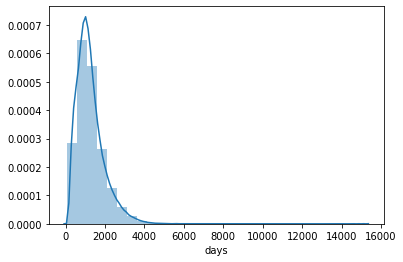

In [70]:
#quick look at the distribution of days in patent pendency
sns.distplot(pat_.days, bins = 30)

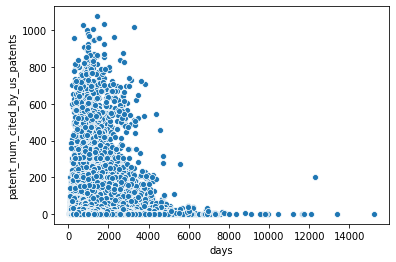

In [79]:
#does the number of days in pendency affect citaions? - seemingly not until outliers
sns.scatterplot(pat_['days'], (pat_['patent_num_cited_by_us_patents']))
plt.show()

Text(0, 0.5, 'Avg. Days in Patent Pendency')

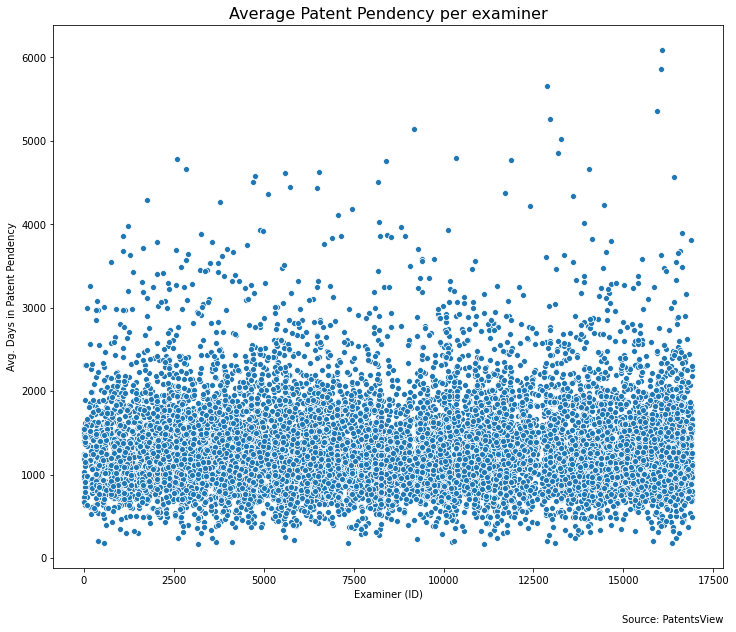

In [89]:
#lets look at the average days per examiner
plt.figure(figsize=(12,10))
sns.scatterplot(pat_.id, pat_.groupby(['id'])['days'].mean())
plt.title('Average Patent Pendency per examiner', fontsize = 16)
plt.annotate('Source: PatentsView', xy=(0.85,-0.10), xycoords="axes fraction")
plt.xlabel('Examiner (ID)')
plt.ylabel('Avg. Days in Patent Pendency')

Text(0, 0.5, 'Days in Patent Pendency')

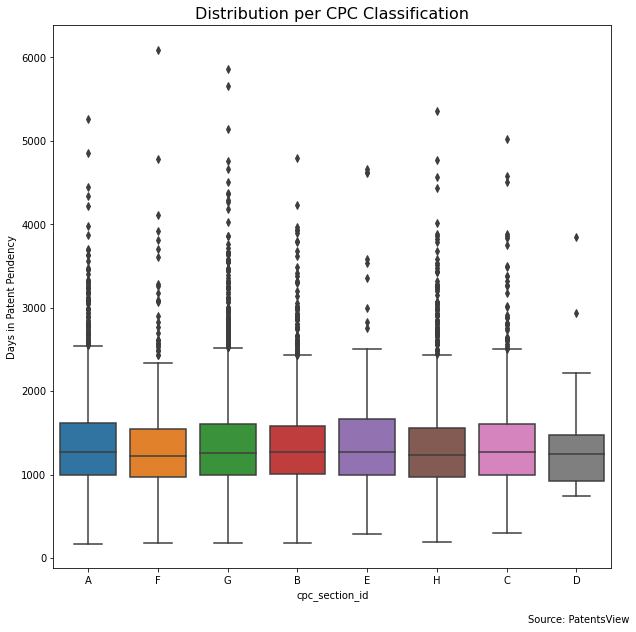

In [91]:
#maybe the cpc sections greatly affect the number of days? - seemingly not
plt.figure(figsize=(10,10))
sns.boxplot(pat_["cpc_section_id"], pat_.groupby(['id'])['days'].mean())
plt.title('Distribution per CPC Classification', fontsize = 16)
plt.annotate('Source: PatentsView', xy=(0.85,-0.10), xycoords="axes fraction")
plt.ylabel('Days in Patent Pendency')

Text(0, 0.5, 'Days in Patent Pendency')

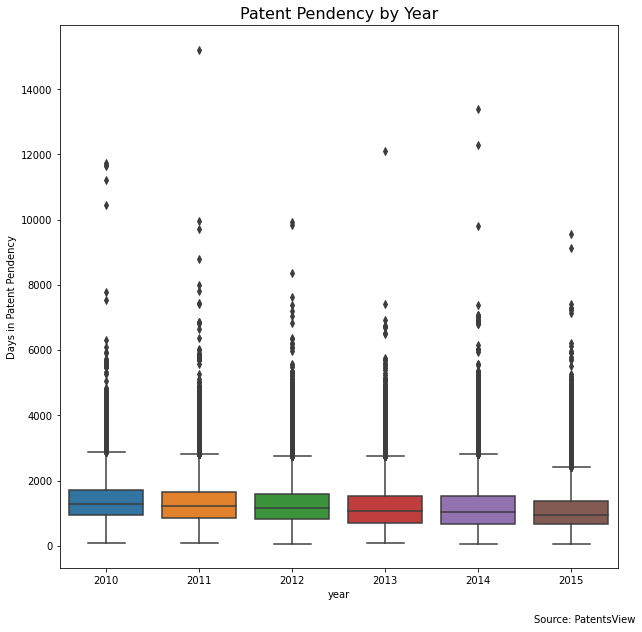

In [104]:
#is patent pendency drastically differetn by year? maybe a little but not much
plt.figure(figsize=(10,10))
sns.boxplot(pat_["year"], pat_['days'])
plt.title('Patent Pendency by Year', fontsize = 16)
plt.annotate('Source: PatentsView', xy=(0.85,-0.10), xycoords="axes fraction")
plt.ylabel('Days in Patent Pendency')

Text(0.85, -0.1, 'Source: PatentsView')

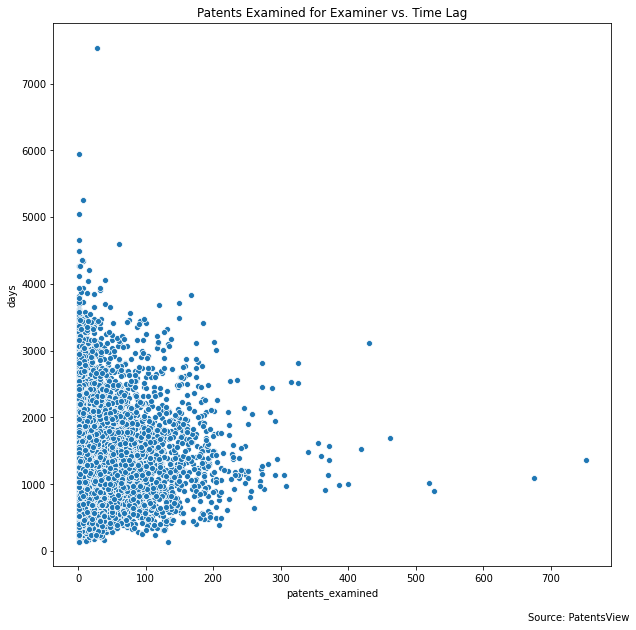

In [95]:
#does the number of patents examined impact how long it takes to get the patent approved
plt.figure(figsize=(10,10))
sns.scatterplot(pat_.groupby(['id'])['patents_examined'].mean(), pat_.days)
plt.title('Patents Examined for Examiner vs. Time Lag')
plt.annotate('Source: PatentsView', xy=(0.85,-0.10), xycoords="axes fraction")

Text(0, 0.5, 'Days in Patent Pendency')

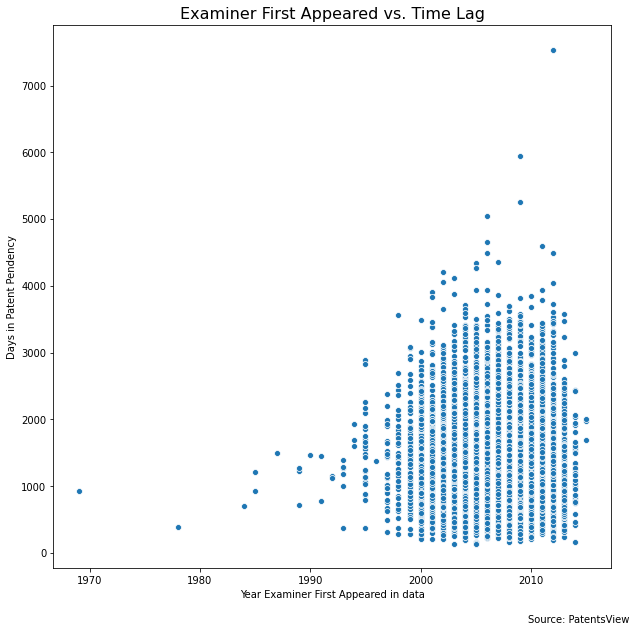

In [131]:
#does examiner experience affect days in patent pendency
plt.figure(figsize=(10,10))
sns.scatterplot(pat_.groupby(['id'])['ex_first_appeared'].mean(), pat_.days)
plt.title('Examiner First Appeared vs. Time Lag', fontsize = 16)
plt.annotate('Source: PatentsView', xy=(0.85,-0.10), xycoords="axes fraction")
plt.xlabel('Year Examiner First Appeared in data')
plt.ylabel('Days in Patent Pendency')

Text(0.5, 0, 'Examiner number of Different Application Types Reviewed')

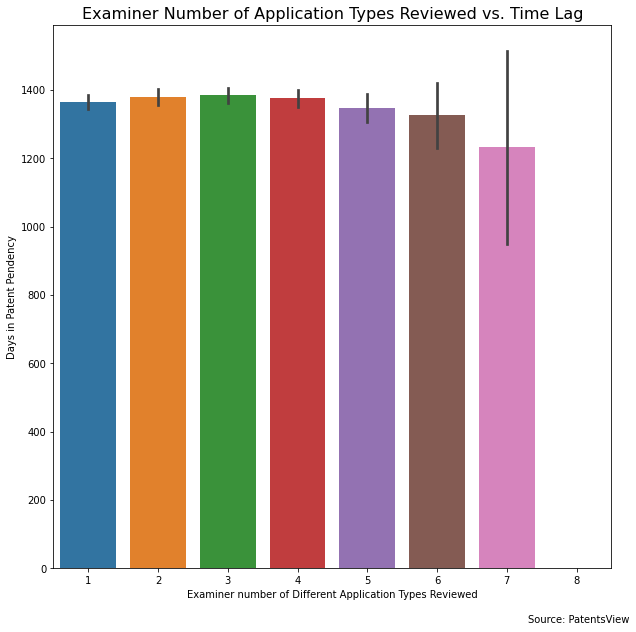

In [132]:
#does number of application types reviewed affect patent pendency
plt.figure(figsize=(10,10))
sns.barplot(pat_.groupby(['id'])['ex_app_types'].mean(), pat_.days)
plt.title('Examiner Number of Application Types Reviewed vs. Time Lag', fontsize = 16)
plt.annotate('Source: PatentsView', xy=(0.85,-0.10), xycoords="axes fraction")
plt.ylabel('Days in Patent Pendency')
plt.xlabel('Examiner number of Different Application Types Reviewed')

## Regressions

In [19]:
pat_.head()

,id,patent_abstract,patent_date,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_num_cited_by_us_patents,patent_title,app_date,app_id,app_type,assignee_key_id,assignee_organization,assignee_total_num_patents,assignee_type,inventor_first_name,inventor_key_id,inventor_last_name,cpc_first_seen_date,cpc_section_id,examiner_first_name,examiner_group,examiner_last_name,days,examiner_name,patents_examined,year,app_year,ex_first_appeared,ex_citations,ex_app_types,ex_cpc_sections
0,9116,A pre-assembled anti-creep waist-clothing stay...,2010-01-05,Baltimore,MD,Baltimore,MD,1,Assembled anti-creep waist-clothing stay devic...,2005-04-01,11/096666,11,372508,"ProductMasters, Inc.",1,2,Catherine,2528735,Chetelat,1976-01-06,A,Katherine,3765,Moran,1740,katherine moran,92,2010,2005,2006,162,3,2
1506,9116,A protective glove for a firefighter or for an...,2010-01-12,Dayton,OH,Dayton,OH,9,Protective glove having inspection port,2006-02-07,11/348680,11,264627,"Morning Pride Manufacturing, L.L.C.",91,2,William L.,769984,"Grilliot, Jr.",1976-01-06,A,Katherine,3765,Moran,1435,katherine moran,92,2010,2006,2006,162,3,2
16222,9116,A head shield device having a frame and a repl...,2010-03-23,Bentonville,AR,San Diego,CA,25,Rotating lens locking device,2006-08-28,11/511865,11,47870,"JT Sports, LLC",19,2,Lester V.,3632185,Broersma,1976-01-27,A,Katherine,3765,Moran,1303,katherine moran,92,2010,2006,2006,162,3,2
21651,9116,A sports glove comprising a dorsal side and at...,2010-04-13,St. Louis,MO,Altamont,NY,6,Sports glove with a segmented joint protector,2007-05-25,11/754239,11,47078,"Rawlings Sporting Goods Company, Inc.",93,2,Paul J.,1760068,Gait,1976-01-06,A,Katherine,3765,Moran,1054,katherine moran,92,2010,2007,2006,162,3,2
23442,9116,An improved goggle strap is provided. The stra...,2010-04-20,Burbank,CA,Dallas,PA,1,Goggle strap,2005-11-23,11/286048,11,196957,"Aramark Cleanroom Services, LLC",1,2,Edward,2557662,Pennell,1976-01-06,A,Katherine,3765,Moran,1609,katherine moran,92,2010,2005,2006,162,3,2


In [139]:
#Initial regression using ordinary least squares, not controlling for application type
lm = smf.ols('days~ex_citations+ex_first_appeared+ex_app_types+ex_cpc_sections+examiner_group+year+patents_examined-1', data=pat_).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   days   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                          1.946e+05
Date:                Thu, 14 May 2020   Prob (F-statistic):                        0.00
Time:                        10:03:20   Log-Likelihood:                     -3.4207e+06
No. Observations:              429240   AIC:                                  6.841e+06
Df Residuals:                  429233   BIC:                                  6.841e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
ex_citations          0.0009      0.001      0.736      0.462      -0.002       0.003
ex_first_appeared    13.2541      0.335     39.586      0.000      12.598      13.910
ex_app_types         23.9506      1.102     21.730      0.000      21.790      26.111
ex_cpc_sections       1.2094      0.865      1.398      0.162      -0.486       2.905
examiner_group       -0.0246      0.001    -16.437      0.000      -0.028      -0.022
year                -12.5798      0.335    -37.602      0.000     -13.235     -11.924
patents_examined     -0.3380      0.013    -26.606      0.000      -0.363      -0.313
==============================================================================
Omnibus:                   125271.226   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           506980.583
Skew:                           1.403   Prob(JB):                         0.00
Kurtosis:                       7.525   Cond. No.                     4.54e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [140]:
#Same as above however we do control for application type
lm1 = smf.ols('days~app_type+ex_citations+ex_first_appeared+ex_app_types+ex_cpc_sections+examiner_group+year+patents_examined-1', data=pat_).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   days   R-squared (uncentered):                   0.902
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                          4.942e+05
Date:                Thu, 14 May 2020   Prob (F-statistic):                        0.00
Time:                        10:03:46   Log-Likelihood:                     -3.2286e+06
No. Observations:              429240   AIC:                                  6.457e+06
Df Residuals:                  429232   BIC:                                  6.457e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_type           -604.0535      0.767   -788.062      0.000    -605.556    -602.551
ex_citations         -0.0125      0.001    -15.515      0.000      -0.014      -0.011
ex_first_appeared   -48.9251      0.228   -214.467      0.000     -49.372     -48.478
ex_app_types        -84.4525      0.718   -117.638      0.000     -85.860     -83.045
ex_cpc_sections       6.8332      0.553     12.357      0.000       5.749       7.917
examiner_group       -0.0070      0.001     -7.322      0.000      -0.009      -0.005
year                 53.1748      0.230    231.623      0.000      52.725      53.625
patents_examined     -0.8138      0.008    -99.938      0.000      -0.830      -0.798
==============================================================================
Omnibus:                    52230.954   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159562.211
Skew:                           0.645   Prob(JB):                         0.00
Kurtosis:                       5.694   Cond. No.                     4.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [141]:
#It appears we are being driven by the application type and the year, can we confirm this? - This model agrees
lm2 = smf.ols('days~app_type+year-1', data=pat_).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   days   R-squared (uncentered):                   0.888
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                          1.710e+06
Date:                Thu, 14 May 2020   Prob (F-statistic):                        0.00
Time:                        10:04:16   Log-Likelihood:                     -3.2566e+06
No. Observations:              429240   AIC:                                  6.513e+06
Df Residuals:                  429238   BIC:                                  6.513e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
app_type    -538.9912      0.763   -706.055      0.000    -540.487    -537.495
year           3.8558      0.005    838.329      0.000       3.847       3.865
==============================================================================
Omnibus:                    62344.339   Durbin-Watson:                   1.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           181663.577
Skew:                           0.778   Prob(JB):                         0.00
Kurtosis:                       5.781   Cond. No.                     2.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
#can we model if/how these affect the citations? - this model tells us we can't the way we're trying to do it
lm3 = smf.ols('patent_num_cited_by_us_patents~days+ex_citations+ex_first_appeared+ex_app_types+ex_cpc_sections+examiner_group+year+patents_examined-1', data=pat_).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     patent_num_cited_by_us_patents   R-squared (uncentered):                   0.087
Model:                                        OLS   Adj. R-squared (uncentered):              0.087
Method:                             Least Squares   F-statistic:                              5132.
Date:                            Thu, 14 May 2020   Prob (F-statistic):                        0.00
Time:                                    09:46:21   Log-Likelihood:                     -2.0592e+06
No. Observations:                          429240   AIC:                                  4.118e+06
Df Residuals:                              429232   BIC:                                  4.118e+06
Df Model:                                       8                                                  
Covariance Type:                        nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
days                  0.0011    6.4e-05     17.262      0.000       0.001       0.001
ex_citations          0.0002   5.29e-05      4.350      0.000       0.000       0.000
ex_first_appeared     0.4135      0.014     29.407      0.000       0.386       0.441
ex_app_types          0.4281      0.046      9.260      0.000       0.338       0.519
ex_cpc_sections       0.4822      0.036     13.299      0.000       0.411       0.553
examiner_group        0.0029   6.27e-05     45.807      0.000       0.003       0.003
year                 -0.4146      0.014    -29.510      0.000      -0.442      -0.387
patents_examined      0.0175      0.001     32.801      0.000       0.016       0.019
==============================================================================
Omnibus:                   807296.868   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1621639924.590
Skew:                          14.466   Prob(JB):                         0.00
Kurtosis:                     302.722   Cond. No.                     4.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
#let's split train and test data and see how our model performs Out of Sample
train = pat_.iloc[:350000, :]
test = pat_.iloc[350000:, :]
train = train[['days', 'examiner_group', 'app_type', 'patents_examined', 'year', 'ex_first_appeared', 'ex_citations', 'ex_app_types', 'ex_cpc_sections']]
test = test[['days', 'examiner_group', 'app_type', 'patents_examined', 'year', 'ex_first_appeared', 'ex_citations', 'ex_app_types', 'ex_cpc_sections']]

In [145]:
#model from earlier
lm4 = smf.ols('days~app_type+ex_citations+ex_first_appeared+ex_app_types+ex_cpc_sections+examiner_group+year+patents_examined-1', data = train).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   days   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                          4.256e+05
Date:                Thu, 14 May 2020   Prob (F-statistic):                        0.00
Time:                        10:09:25   Log-Likelihood:                     -2.6260e+06
No. Observations:              350000   AIC:                                  5.252e+06
Df Residuals:                  349992   BIC:                                  5.252e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_type           -616.6118      0.857   -719.515      0.000    -618.291    -614.932
ex_citations         -0.0098      0.001    -11.888      0.000      -0.011      -0.008
ex_first_appeared   -46.0891      0.250   -184.536      0.000     -46.579     -45.600
ex_app_types        -79.2166      0.781   -101.416      0.000     -80.748     -77.686
ex_cpc_sections       6.3960      0.601     10.645      0.000       5.218       7.574
examiner_group       -0.0171      0.001    -16.410      0.000      -0.019      -0.015
year                 50.3717      0.251    200.449      0.000      49.879      50.864
patents_examined     -0.2112      0.009    -24.099      0.000      -0.228      -0.194
==============================================================================
Omnibus:                    45899.539   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           143531.783
Skew:                           0.686   Prob(JB):                         0.00
Kurtosis:                       5.821   Cond. No.                     5.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
#See out of sample R2 score - performs OK, but not great
r2_score(test.days,lm4.predict(test.iloc[:,1:]))

0.49706891432425593

In [61]:
#testtrainsplit the data more formally, we will try to regularize the model to fight multicopllinearity
from sklearn.model_selection import train_test_split
X = pat_[['year', 'app_type','examiner_group','patents_examined', 'ex_first_appeared', 'ex_citations', 'ex_app_types', 'ex_cpc_sections']]
y = pat_[['days']]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [62]:
#try Ridge with an arbitrary regularization parameter alpha=1
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(X_train, Y_train)
# In sample Prediction:
YPred_IS=Ridge.predict(X_train)
print("The IS R-squared of Ridge is: {0}".format(r2_score(Y_train,YPred_IS)))
Ridge.coef_

The IS R-squared of Ridge is: 0.7953307826585847


array([[ 2.89055156e+02, -8.74665770e+02, -1.27379261e-02,
        -9.57411452e-02, -2.73604010e-01,  3.54644210e-04,
        -2.50003724e+00,  9.82937818e-01]])

In [63]:
#Out of sample Prediction
YPred_OS=Ridge.predict(X_test)
print("The OS R-squared of Ridge is: {0}".format(r2_score(Y_test,YPred_OS)))

The OS R-squared of Ridge is: 0.7946816174599148


In [64]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.1)

Lasso.fit(X_train, Y_train)
# In sample:
YPred_IS=Lasso.predict(X_train)
print("The IS R-squared of Lasso is: {0}".format(r2_score(Y_train,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(X_test)
print("The OS R-squared of Lasso is: {0}".format(r2_score(Y_test,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.7953306336297346
The OS R-squared of Lasso is: 0.7946828266016812


array([ 2.88914409e+02, -8.74395505e+02, -1.27342118e-02, -9.59376089e-02,
       -2.36487874e-01,  3.46994022e-04, -2.32426428e+00,  8.82190180e-01])

In [ ]:
#These help our model a little, but not a ton, the coefficients of each show that year and app_type are mostly all that matter for the model